### Data Checks

Check keys: the key is made of `upc`, `calendar_date`, `store_id`, `geography_id`

* Which products are in all files? Only include products which we have complete data set for
* Do store IDs appear in mulitple geographys?
* Is `calendar_date` consistent across all files. Only include date range where we have all data.

In [1]:
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d')

In [3]:
fore = pd.read_csv('../data/Case Study - Forecast Data.txt', sep='\t', encoding='utf-16',
                   parse_dates=['calendar_id'], date_parser=dateparse)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [4]:
depot = pd.read_csv('../data/Case Study - Depot Data.txt', sep='\t', encoding='utf-16',
                    parse_dates=['calendar_id'], date_parser=dateparse)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [5]:
instore = pd.read_csv('../data/Case Study - In Store Data.txt', sep='\t', encoding='utf-16',
                      parse_dates=['calendar_id'], date_parser=dateparse)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [6]:
cinv = pd.read_csv('../data/Case Study - Closing Inventory.txt', sep='\t', encoding='utf-16',
                   parse_dates=['calendar_id'], date_parser=dateparse)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


### What are the shapes of the data?

In [7]:
fore.shape

(2648539, 34)

In [11]:
fore.shape[0] == depot.shape[0] == cinv.shape[0] == instore.shape[0]

True

All are the same shape

#### Date range

In [15]:
def return_daterange(df):
    return df['calendar_id'].min(), df['calendar_id'].max()

In [16]:
return_daterange(fore), return_daterange(depot), return_daterange(cinv), return_daterange(instore)

((Timestamp('2018-07-07 00:00:00'), Timestamp('2018-08-06 00:00:00')),
 (Timestamp('2018-07-07 00:00:00'), Timestamp('2018-08-06 00:00:00')),
 (Timestamp('2018-07-07 00:00:00'), Timestamp('2018-08-06 00:00:00')),
 (Timestamp('2018-07-07 00:00:00'), Timestamp('2018-08-06 00:00:00')))

In [17]:
instore['calendar_id'].unique()

array(['2018-07-07T00:00:00.000000000', '2018-07-08T00:00:00.000000000',
       '2018-07-09T00:00:00.000000000', '2018-07-10T00:00:00.000000000',
       '2018-07-11T00:00:00.000000000', '2018-07-12T00:00:00.000000000',
       '2018-07-13T00:00:00.000000000', '2018-07-14T00:00:00.000000000',
       '2018-07-15T00:00:00.000000000', '2018-07-16T00:00:00.000000000',
       '2018-07-17T00:00:00.000000000', '2018-07-18T00:00:00.000000000',
       '2018-07-19T00:00:00.000000000', '2018-07-20T00:00:00.000000000',
       '2018-07-21T00:00:00.000000000', '2018-07-22T00:00:00.000000000',
       '2018-07-23T00:00:00.000000000', '2018-07-24T00:00:00.000000000',
       '2018-07-25T00:00:00.000000000', '2018-07-26T00:00:00.000000000',
       '2018-07-27T00:00:00.000000000', '2018-07-28T00:00:00.000000000',
       '2018-07-29T00:00:00.000000000', '2018-07-30T00:00:00.000000000',
       '2018-07-31T00:00:00.000000000', '2018-08-01T00:00:00.000000000',
       '2018-08-02T00:00:00.000000000', '2018-08-03

#### Stores in multiple geographies?

In [18]:
(fore.groupby('store_id')['geography_id'].nunique() == 1).value_counts()

True    623
Name: geography_id, dtype: int64

In [19]:
(cinv.groupby('store_id')['geography_id'].nunique() == 1).value_counts()

True    623
Name: geography_id, dtype: int64

In [20]:
pd.merge(pd.DataFrame(fore['upc'].drop_duplicates()), pd.DataFrame(depot['upc'].drop_duplicates()), how='outer').shape

(143, 1)

All files have:
* dates between 08.01.2018 and 07.12.2018
* Store IDs that only one appear in one geography
* 143 products

#### Is Closing Inv the same In Store?

In [21]:
(cinv == instore[cinv.columns]).apply(lambda x: x.value_counts()).transpose()

,False,True
upc,NaN,2648539.0
calendar_date,NaN,2648539.0
calendar_id,NaN,2648539.0
store_id,NaN,2648539.0
geography_id,NaN,2648539.0
shelf_life,NaN,2648539.0
units_per_tray,NaN,2648539.0
closing_inventory_min_neg_over_shelf_life_minus_2_days,2554345.0,94194.0
closing_inventory_neg_count_over_1_day,NaN,2648539.0
closing_inventory_neg_count_over_shelf_life_minus_2_days,NaN,2648539.0


**Note:** Closing Inventory and In Store are identical except for:
* closing_inventory_min_neg_over_shelf_life_minus_2_days
* closing_inventory_on_day

Join these to final data with `cinv` prefix

**Note2:** the files are the same. The only differences are from NA values failing match.

### Forecast data

### Forecast

* No negative: forecast demand, waste prediction

In [22]:
fore['forecast_demand_on_day'].min(), fore['predicted_waste_on_day'].min()

(0.0, 0.0)

### Depot

* depot_delivered_qty_on_day should be positive
* depot_lvl_required_qty_over_supplier_lead_time many negative? Is this right?

In [23]:
(depot['depot_delivered_qty_on_day'] < 0).value_counts()

False    2648464
True          75
Name: depot_delivered_qty_on_day, dtype: int64

Remove negative depot_delivered_qty_on_day rows from data

In [24]:
(depot['depot_lvl_required_qty_over_supplier_lead_time'] < 0).value_counts()

False    2149185
True      499354
Name: depot_lvl_required_qty_over_supplier_lead_time, dtype: int64

In [25]:
(depot['depot_ordered_qty_over_supplier_lead_time'] < 0).value_counts()

False    2648539
Name: depot_ordered_qty_over_supplier_lead_time, dtype: int64

### In Store

* waste_value_on_day cannot be negative. How does a fraction of waste work? Is this a tray unit, the effect of the reduced price?
* **Removed:** stock_out_ind_on_day & ranging_indicator_on_day should be 0 or 1 and mutually exclusive. Misunderstanding of meaning

In [26]:
(instore['waste_value_on_day'] < 0 ).value_counts()

False    2648537
True           2
Name: waste_value_on_day, dtype: int64

In [27]:
(instore['stock_out_ind_on_day'] + instore['ranging_indicator_on_day']).value_counts()

1.0    1650382
2.0     130273
0.0      11806
dtype: int64

Remove rows which do not equal 1 (0 and 2)

### Closing Inventory

* Second column called closing_inventory_on_day

In [28]:
(instore['closing_inventory_on_day'] == cinv['closing_inventory_on_day']).value_counts()

True     1792461
False     856078
Name: closing_inventory_on_day, dtype: int64

In [29]:
instore['closing_inventory_on_day'].isna().value_counts()

False    1792461
True      856078
Name: closing_inventory_on_day, dtype: int64

In [30]:
cinv['closing_inventory_on_day'].isna().value_counts()

False    1792461
True      856078
Name: closing_inventory_on_day, dtype: int64

They are the same column

In [31]:
(cinv['closing_inventory_on_day'] < 0).value_counts()

False    2612704
True       35835
Name: closing_inventory_on_day, dtype: int64

Can't have a negative closing inventory

### Review Outliers

Look at `sales_value_on_day`

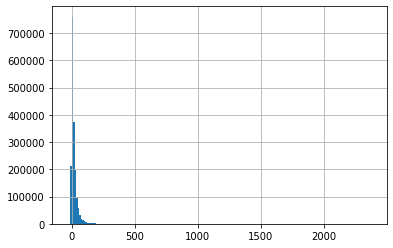

In [32]:
instore['sales_value_on_day'].hist(bins=200)

#### Store-level and product-level review

In [33]:
store_product = instore[(instore['upc']==155915) & (instore['store_id']==1312)]

In [34]:
z_scores = pd.DataFrame(stats.zscore(store_product['sales_value_on_day'], nan_policy='omit'))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x103fee090>]],
      dtype=object)

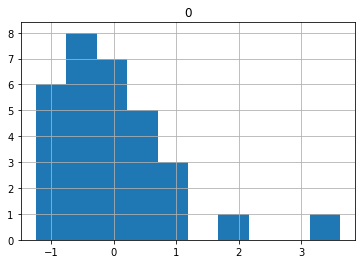

In [35]:
z_scores.hist()

In [36]:
def outlier_rows(df, col):
    z_scores = pd.DataFrame(stats.zscore(df[col], nan_policy='omit'))
    return df.reset_index()[(z_scores[0] > 3)].drop(['index'], axis=1)

In [37]:
store = instore[(instore['store_id']==1312)]

In [38]:
store.shape

(4384, 26)

In [39]:
store.groupby(['upc', 'store_id']).apply(outlier_rows, ('sales_value_on_day')).reset_index(drop=True)

/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2413: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(a=a, axis=axis, keepdims=True)
/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


,upc,calendar_date,calendar_id,store_id,geography_id,shelf_life,units_per_tray,cal_gross_sales_qty_on_day,closing_inventory_min_neg_over_shelf_life_minus_2_days,closing_inventory_neg_count_over_1_day,...,sales_qty_over_lead_time,sales_qty_over_shelf_life,sales_value_on_day,stock_adj_over_shelf_life_exclude_event_date,stock_out_ind_on_day,stockfile_adjust_neg_count_over_minus_1_day,stockfile_adjust_qty_at_minus_1_day,stockfile_adjust_qty_at_plus_1_day,stockfile_adjust_qty_on_day,waste_value_on_day
0,109024,20/07/2018 00:00:00,2018-07-20,1312,4212,6,16,72.0,NaN,0,...,104.0,183.0,144.00,-1.0,0.0,0,NaN,NaN,NaN,0.0
1,146654,23/07/2018 00:00:00,2018-07-23,1312,4212,7,12,6.0,NaN,0,...,7.0,15.0,9.00,-1.0,0.0,0,NaN,NaN,NaN,0.0
2,154741,11/07/2018 00:00:00,2018-07-11,1312,4212,7,12,16.0,NaN,0,...,23.0,49.0,68.00,0.0,0.0,0,NaN,NaN,NaN,0.0
3,155090,14/07/2018 00:00:00,2018-07-14,1312,4212,14,24,16.0,NaN,0,...,27.0,55.0,128.00,-14.0,0.0,0,NaN,NaN,NaN,0.0
4,155915,07/07/2018 00:00:00,2018-07-07,1312,4212,7,14,106.0,NaN,0,...,106.0,106.0,371.00,0.0,0.0,0,NaN,NaN,NaN,3.5
5,156066,27/07/2018 00:00:00,2018-07-27,1312,4212,14,12,6.0,NaN,0,...,7.0,23.0,36.00,0.0,0.0,0,NaN,NaN,NaN,0.0
6,187190,28/07/2018 00:00:00,2018-07-28,1312,4212,10,5,28.0,NaN,0,...,39.0,146.0,14.00,0.0,0.0,0,NaN,NaN,NaN,0.0
7,196819,14/07/2018 00:00:00,2018-07-14,1312,4212,3,12,58.0,NaN,0,...,99.0,170.0,127.60,0.0,0.0,0,NaN,NaN,NaN,0.0
8,225380,14/07/2018 00:00:00,2018-07-14,1312,4212,7,8,77.0,NaN,0,...,126.0,319.0,308.00,0.0,0.0,0,NaN,NaN,NaN,0.0
9,255110,04/08/2018 00:00:00,2018-08-04,1312,4212,7,6,13.0,NaN,0,...,18.0,48.0,91.00,0.0,0.0,0,NaN,NaN,NaN,0.0


In [40]:
# Sales 3 standard deviations above the mean sales

outlier_rows(store_product, 'sales_value_on_day')

,upc,calendar_date,calendar_id,store_id,geography_id,shelf_life,units_per_tray,cal_gross_sales_qty_on_day,closing_inventory_min_neg_over_shelf_life_minus_2_days,closing_inventory_neg_count_over_1_day,...,sales_qty_over_lead_time,sales_qty_over_shelf_life,sales_value_on_day,stock_adj_over_shelf_life_exclude_event_date,stock_out_ind_on_day,stockfile_adjust_neg_count_over_minus_1_day,stockfile_adjust_qty_at_minus_1_day,stockfile_adjust_qty_at_plus_1_day,stockfile_adjust_qty_on_day,waste_value_on_day
0,155915,07/07/2018 00:00:00,2018-07-07,1312,4212,7,14,106.0,NaN,0,...,106.0,106.0,371.0,0.0,0.0,0,NaN,NaN,NaN,3.5


### Next: 
1. depot_delivered_qty_on_day remove where negative
2. closing_inventory_on_day remove where negative
3. waste_value_on_day remove where negative
4. **Removed:** Remove rows where (instore['stock_out_ind_on_day'] + instore['ranging_indicator_on_day']) != 1

### Notes:
* Could remove values in key columns that are more than 3 sd from mean. Investigate whether salse are possible by how many are available
* Check in what cases you can sell more than the delivered quantity over the shelf life

In [41]:
instore[instore['delivered_qty_over_shelf_life'] < instore['sales_value_on_day']][['sales_value_on_day','delivered_qty_over_shelf_life']]

,sales_value_on_day,delivered_qty_over_shelf_life
0,30.00,20.0
6,59.80,0.0
8,110.25,44.0
9,18.00,0.0
10,31.50,8.0
...,...,...
2648437,30.55,18.0
2648439,55.00,48.0
2648455,33.00,32.0
2648496,20.00,18.0


In [42]:
store_1312 = instore[(instore['upc'] == 155915) & (instore['store_id'] == 1312)][['sales_value_on_day', 'delivered_qty_over_shelf_life']]
store_1312.head()

,sales_value_on_day,delivered_qty_over_shelf_life
60,371.0,112.0
99857,143.5,126.0
247586,161.0,182.0
293843,56.0,210.0
398557,185.5,238.0


In [43]:
store_1312[store_1312['sales_value_on_day'] > store_1312['delivered_qty_over_shelf_life']]

,sales_value_on_day,delivered_qty_over_shelf_life
60,371.0,112.0
99857,143.5,126.0
